In [1]:
import torch
import torchaudio.functional as F
import librosa
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

from torchsummary import summary
from torchaudio.transforms import Spectrogram
from scipy.signal import butter, lfilter

from models import *
from utils import *
from dataloading import *

/home/lukas/miniconda3/envs/master-thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(f'Using device {device}')

Using device cpu


# Utility functions

In [3]:
SPECTROGRAM_SETTINGS = {
    'n_fft': 512,
}

spec_transform = Spectrogram(**SPECTROGRAM_SETTINGS)

In [4]:
def plot_waveform(waveform, sample_rate=32_000, title='Waveform', ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)

    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(waveform, title='Spectrogram', ylabel='freq_bin', ax=None):
    spectrogram = spec_transform(waveform)[0]

    if ax is None:
        _, ax = plt.subplots(1, 1)
    
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.imshow(librosa.power_to_db(spectrogram), origin='lower', aspect='auto', interpolation='nearest')


def plot_pitch(waveform, sample_rate=32_000, title='Pitch Features', ax=None):
    pitch = F.detect_pitch_frequency(waveform, sample_rate)

    if ax is None:
        _, ax = plt.subplots(1, 1)
    
    ax.set_title(title)
    ax.grid(True)

    end_time = waveform.shape[1] / sample_rate
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    ax.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

    ax2 = ax.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    ax2.plot(time_axis, pitch[0], linewidth=2, label='Pitch', color='green')
    ax2.legend(loc=0)

def plot_waveform_histogram(waveform, ax, color, label, sample_rate=32_000, n_fft=512, hop_length=256):
    waveform = waveform.numpy()
    
    stft_result = librosa.stft(waveform, n_fft=n_fft, hop_length=hop_length)
    stft_magnitude = np.abs(stft_result)

    # Calculate the corresponding frequencies
    freqs = librosa.fft_frequencies(sr=sample_rate, n_fft=n_fft)

    # Compute the mean amplitude over all time frames for each frequency
    mean_amplitude = np.mean(stft_magnitude, axis=1)

    # Plotting the histogram
    ax.bar(freqs, mean_amplitude, width=freqs[1] - freqs[0], color=color, alpha=0.6, label=label)

# Load data and pipeline model

In [5]:
train_loader, test_loader = load_ESC50(batch_size=4, load_mono=False)

train_dataset = train_loader.dataset
test_dataset = test_loader.dataset

=> Dataset training fold 1 selection out of 2000
=>  for training remains 1600
=> Dataset testing fold 1 selection out of 2000
=>  for testing remains 400


In [6]:
checkpoint_path = '../experiment-results/AE-ESC50-09 Experiment/best_val_model.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)

autoencoder = AudioAutoencoder(reduce_output=True)
classifier = get_mobilenet(checkpoint='models/pretrained_weights/ESC50_mn10_esc50_epoch_79_acc_960.pt')

mel_transform = MelTransform()
pipeline = CombinedPipeline(autoencoder=autoencoder, classifier=classifier, finetune_encoder=False, post_ae_transform=mel_transform).to(device)
pipeline.load_state_dict(checkpoint['model_state_dict'])
pipeline.eval();

/home/lukas/miniconda3/envs/master-thesis/lib/python3.11/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


Number of classes defined: 50, but try to load pre-trained layer with logits: 527
Dropping last layer.
Error(s) in loading state_dict for MN:
	Missing key(s) in state_dict: "classifier.5.weight", "classifier.5.bias". 
Loading weights pre-trained weights in a non-strict manner.
=> Loading checkpoint models/pretrained_weights/ESC50_mn10_esc50_epoch_79_acc_960.pt
=> Freezing encoder


# Inpsect loss curves

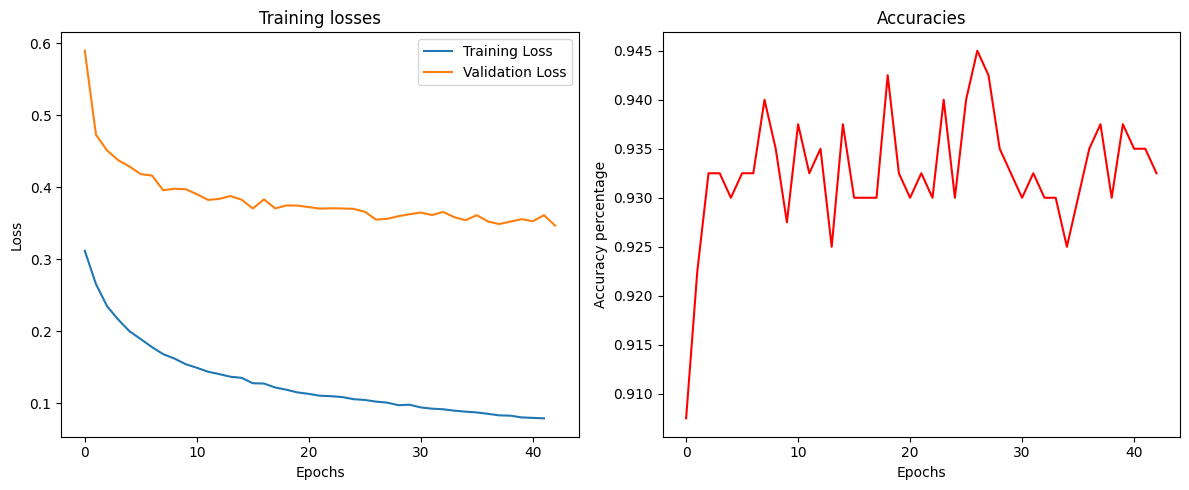

Best accuracy 0.945 at Epoch 26
Final accuracy 0.9325

Best validation loss 0.3465 at Epoch 42
Final validation loss 0.3465


In [9]:
training_losses = np.array(checkpoint['training_losses'])
validation_losses = np.array(checkpoint['validation_losses'])
accuracies = np.array(checkpoint['accuracies'])

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Training loss
ax1.plot(range(len(training_losses)), training_losses, label='Training Loss')
ax1.plot(range(len(validation_losses)), validation_losses, label='Validation Loss')
ax1.set_title('Training losses')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracies
ax2.plot(range(len(accuracies)), accuracies, color='red')
ax2.set_title('Accuracies')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy percentage')

plt.tight_layout()
plt.show()

print(f'Best accuracy {max(accuracies):.4} at Epoch {np.argmax(accuracies)}')
print(f'Final accuracy {accuracies[-1]:.4}\n')

print(f'Best validation loss {min(validation_losses):.4} at Epoch {np.argmin(validation_losses)}')
print(f'Final validation loss {validation_losses[-1]:.4}')

# Inspect AE results

In [10]:
CLASS_NAMES = ['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'rain', 'sea waves', 'crackling fire', 'crickets', 'chirping birds', 'water drops', 'wind', 'Pouring water', 'Toilet flush', 'thunderstorm', 'baby crying', 'sneezing', 
               'clapping', 'breathing', 'coughing', 'footsteps', 'laughing', 'tooth brushing', 'snoring', 'drinking / sipping', 'knocking', 'mouse click', 'keyboard typing', 'creaks (door/wood)', 'can opening', 'washing machine', 'vacuum cleaner', 'alarm clock', 
               'ticking clock', 'glass breaking', 'helicopter', 'chainsaw', 'siren', 'car horn', 'engine', 'train', 'church bells', 'airplane', 'fireworks', 'hand saw']

In [81]:
# Audio file 40 is very interesting because it shows that only lower frequencies get reconstructed
# Audio file -1 is very interesting because it shows that when light frequencies are still present, the autoencoder amplifies them


AUDIO_FILE_INDEX = 40
# waveform, target = test_dataset[AUDIO_FILE_INDEX]
# waveform = torch.tensor(waveform)

waveform, target = train_dataset[AUDIO_FILE_INDEX]
waveform = torch.tensor(waveform)

print(waveform.shape)

print(CLASS_NAMES[target.argmax()])

torch.Size([2, 160000])
engine


## Original audio wave

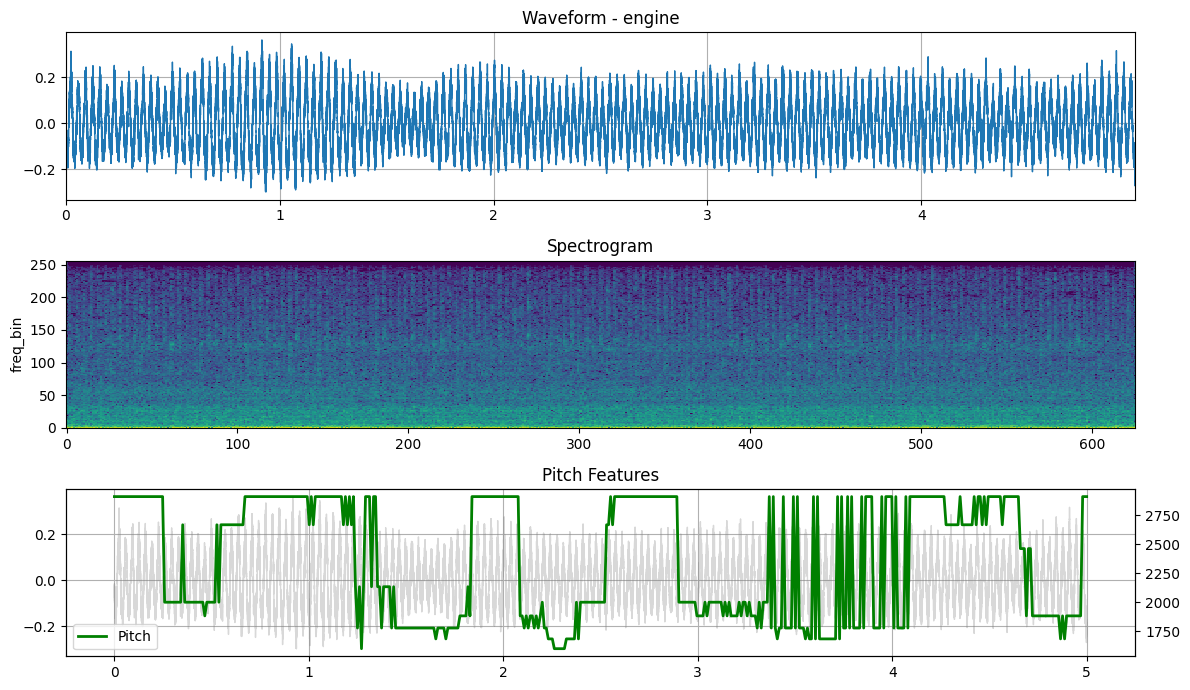

In [82]:
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
plot_waveform(waveform.mean(axis=0, keepdim=True), title=f'Waveform - {CLASS_NAMES[target.argmax()]}', ax=axs[0])
plot_spectrogram(waveform.mean(axis=0, keepdim=True), ax=axs[1])
plot_pitch(waveform.mean(axis=0, keepdim=True), ax=axs[2])
fig.tight_layout()

ipd.Audio(waveform.mean(axis=0, keepdim=True), rate=32_000)

## Base AE reconstruction

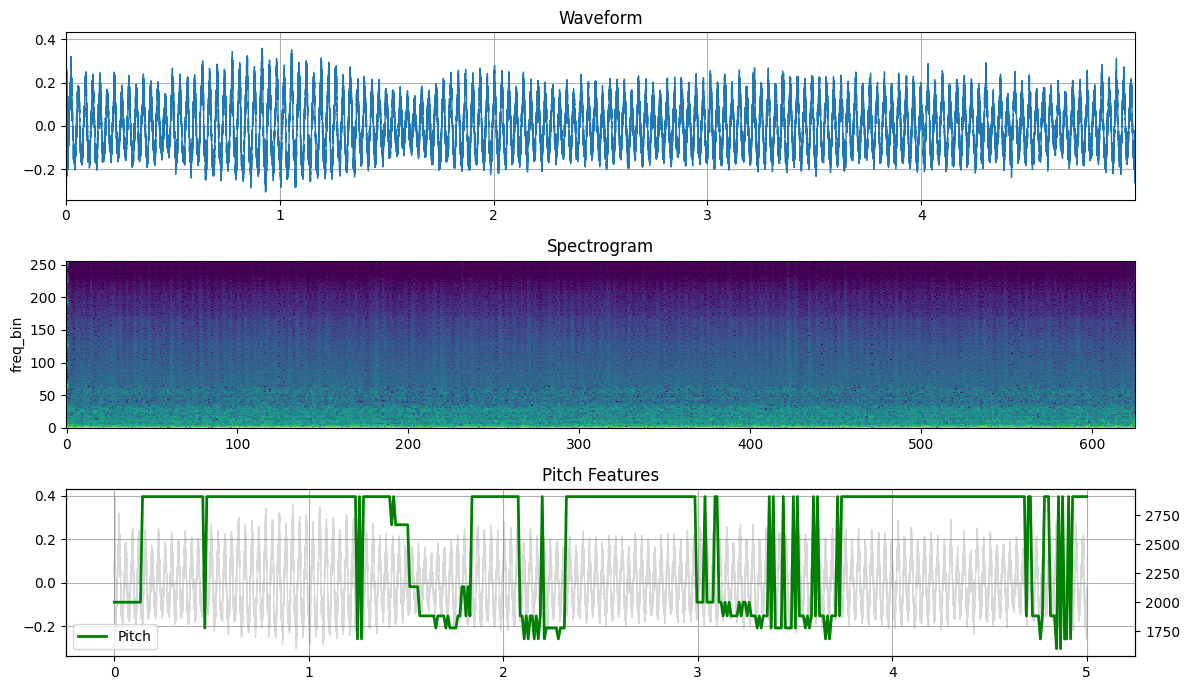

In [83]:
base_autoencoder = AudioAutoencoder(reduce_output=True).to(device)
base_reconstructed_waveform = base_autoencoder(waveform[None, :].to(device)).detach().cpu()[0]

fig, axs = plt.subplots(3, 1, figsize=(12, 7))
plot_waveform(base_reconstructed_waveform, ax=axs[0])
plot_spectrogram(base_reconstructed_waveform, ax=axs[1])
plot_pitch(base_reconstructed_waveform, ax=axs[2])
fig.tight_layout()

ipd.Audio(base_reconstructed_waveform, rate=32_000)

## Fine-tunde AE reconstruction

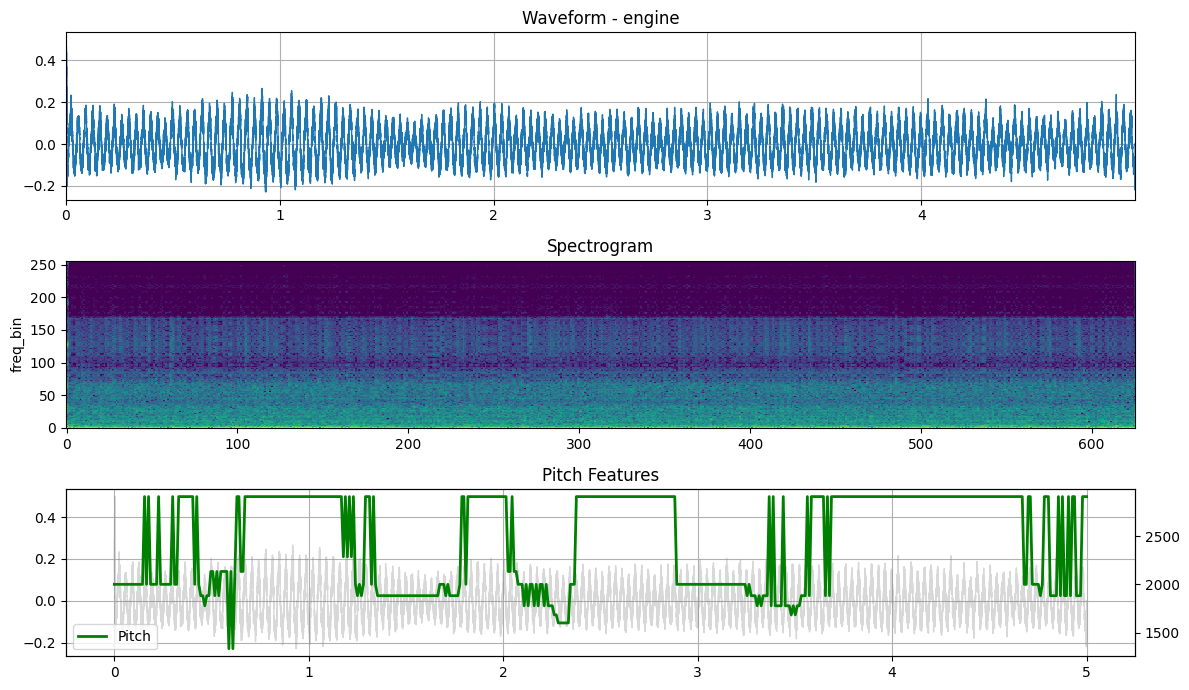

In [84]:
fine_reconstructed_waveform = pipeline.autoencoder(waveform[None,:].to(device)).detach().cpu()[0]
fine_predictions = pipeline(waveform[None,:].to(device)).detach().cpu()[0]

fig, axs = plt.subplots(3, 1, figsize=(12, 7))
plot_waveform(fine_reconstructed_waveform, title=f'Waveform - {CLASS_NAMES[fine_predictions.argmax()]}', ax=axs[0])
plot_spectrogram(fine_reconstructed_waveform, ax=axs[1])
plot_pitch(fine_reconstructed_waveform, ax=axs[2])
fig.tight_layout()

ipd.Audio(fine_reconstructed_waveform, rate=32_000)

## Difference in audio waveforms

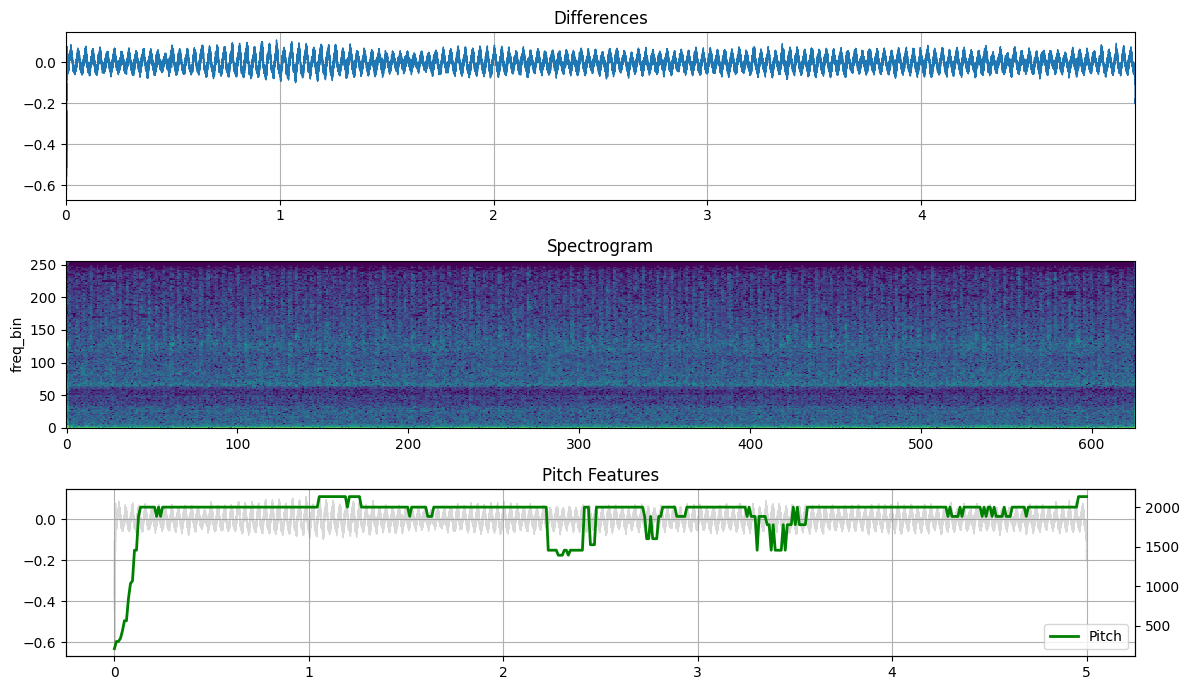

In [85]:
differences = waveform.mean(axis=0, keepdim=True) - fine_reconstructed_waveform

fig, axs = plt.subplots(3, 1, figsize=(12, 7))
plot_waveform(differences, title=f'Differences', ax=axs[0])
plot_spectrogram(differences, ax=axs[1])
plot_pitch(differences, ax=axs[2])
fig.tight_layout()

ipd.Audio(differences, rate=32_000)

## Compare spectrograms

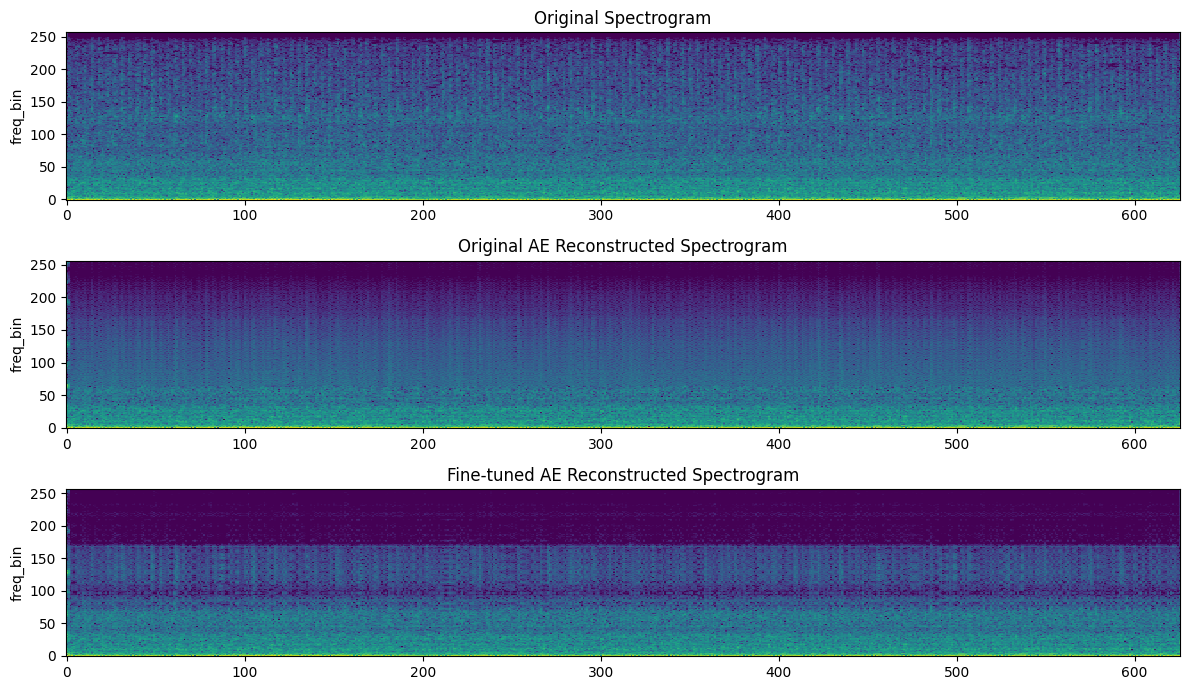

In [86]:
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
plot_spectrogram(waveform.mean(axis=0, keepdim=True), title='Original Spectrogram', ax=axs[0])
plot_spectrogram(base_reconstructed_waveform, title='Original AE Reconstructed Spectrogram', ax=axs[1])
plot_spectrogram(fine_reconstructed_waveform, title='Fine-tuned AE Reconstructed Spectrogram', ax=axs[2])
fig.tight_layout()

## Inspect Mel-Inputs to classifier

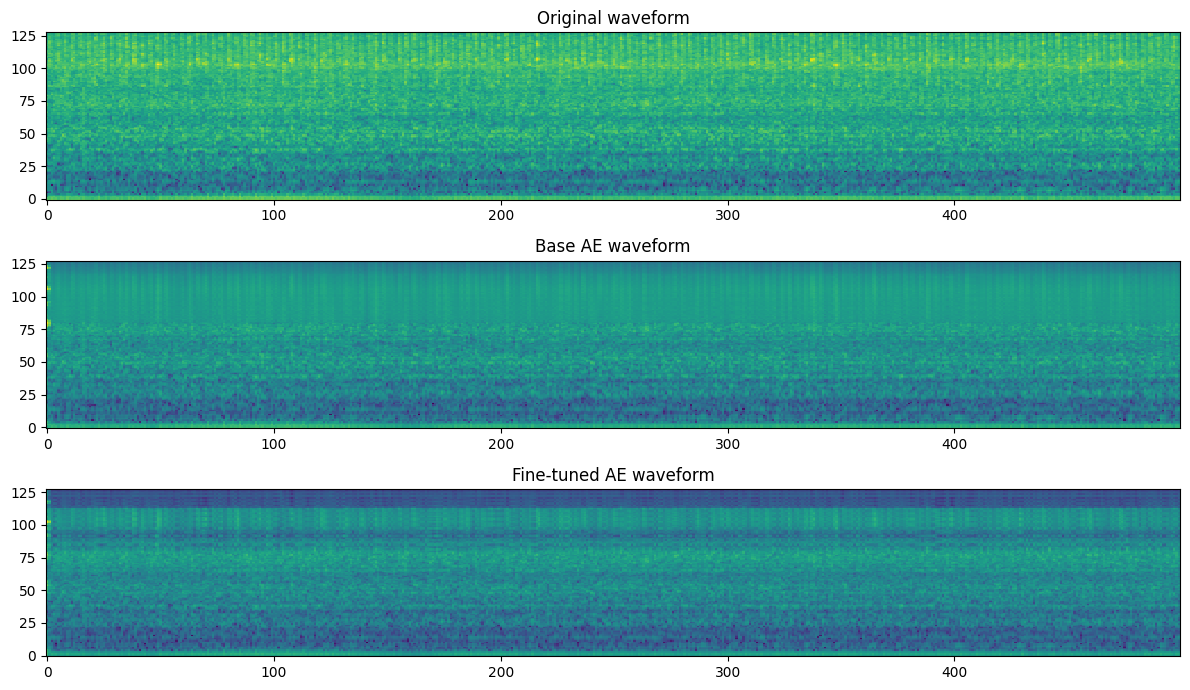

In [87]:
plain_mel_transformed = mel_transform(waveform.mean(axis=0, keepdim=True)[None, :].to(device)).detach().cpu()[0]
base_mel_transformed  = mel_transform(base_autoencoder(waveform[None, :].to(device))).detach().cpu()[0]
fine_mel_transformed  = mel_transform(pipeline.autoencoder(waveform[None, :].to(device))).detach().cpu()[0]

fig, axs = plt.subplots(3, 1, figsize=(12, 7))

axs[0].imshow(plain_mel_transformed[0], origin='lower', aspect='auto', interpolation='nearest')
axs[0].set_title('Original waveform')

axs[1].imshow(base_mel_transformed[0], origin='lower', aspect='auto', interpolation='nearest')
axs[1].set_title('Base AE waveform')

axs[2].imshow(fine_mel_transformed[0], origin='lower', aspect='auto', interpolation='nearest')
axs[2].set_title('Fine-tuned AE waveform')

fig.tight_layout()

# Inpsect frequency histograms

In [88]:
# fig, axs = plt.subplots(1, 1, figsize=(12, 7))
# plot_waveform_histogram(waveform.mean(axis=0, keepdim=True)[0], axs, color='skyblue', label='Original Waveform')
# plot_waveform_histogram(base_autoencoder(waveform[None, :].to(device)).detach().cpu()[0][0], axs, color='green', label='Base AE Reconstruction')
# plot_waveform_histogram(pipeline.autoencoder(waveform[None, :].to(device)).detach().cpu()[0][0], axs, color='orange', label='Finetuned AE Reconstruction')
# 
# plt.title("Amplitude vs Frequency Histogram (using STFT)")
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Mean Amplitude")
# plt.grid(True)
# plt.legend()
# plt.show()

In [89]:
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = 'iframe'

def plot_waveform_histogram(waveform, color, label, sample_rate=32_000, n_fft=512, hop_length=256):
    waveform = waveform.numpy()
    
    # Compute STFT
    stft_result = librosa.stft(waveform, n_fft=n_fft, hop_length=hop_length)
    stft_magnitude = np.abs(stft_result)

    # Calculate frequencies
    freqs = librosa.fft_frequencies(sr=sample_rate, n_fft=n_fft)

    # Compute mean amplitude
    mean_amplitude = np.mean(stft_magnitude, axis=1)

    # Create Plotly bar trace
    trace = go.Bar(
        x=freqs,
        y=mean_amplitude,
        name=label,
        marker_color=color,
        opacity=0.6,
        hoverinfo='x+y',
        hoverlabel=dict(namelength=0)
    )

    return trace

# Initialize traces
traces = []

# Add the histograms
traces.append(plot_waveform_histogram(waveform.mean(axis=0, keepdim=True)[0], 'skyblue', 'Original Waveform'))
traces.append(plot_waveform_histogram(base_autoencoder(waveform[None, :].to(device)).detach().cpu()[0][0], 'green', 'Base AE Reconstruction'))
traces.append(plot_waveform_histogram(pipeline.autoencoder(waveform[None, :].to(device)).detach().cpu()[0][0], 'orange', 'Finetuned AE Reconstruction'))

# Create figure
fig = go.Figure(traces)

# Update layout
fig.update_layout(
    title="Amplitude vs Frequency Histogram (using STFT)",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Mean Amplitude",
    barmode='overlay',
    hovermode='x',
    legend_title="Waveforms",
    legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99),
    template="plotly_white"
)

# Display the figure
fig.show()

# Anaylsing Frequencies

In [90]:
def bandpass_filter(waveform, low_bound, high_bound):
    spectrogram = librosa.stft(noise, n_fft=512, hop_length=256)
    frequencies = librosa.fft_frequencies(sr=32_000, n_fft=512)
    
    # bandpass filtering by zeroing out all other frequencies outside 200-250 Hz
    D_filtered = np.copy(spectrogram)
    D_filtered[:, (frequencies < low_bound) | (frequencies > high_bound)] = 0
    
    # recover the signal
    recovered_signal = librosa.istft(D_filtered, hop_length=256)
    return recovered_signal

 ## Frequency Tests

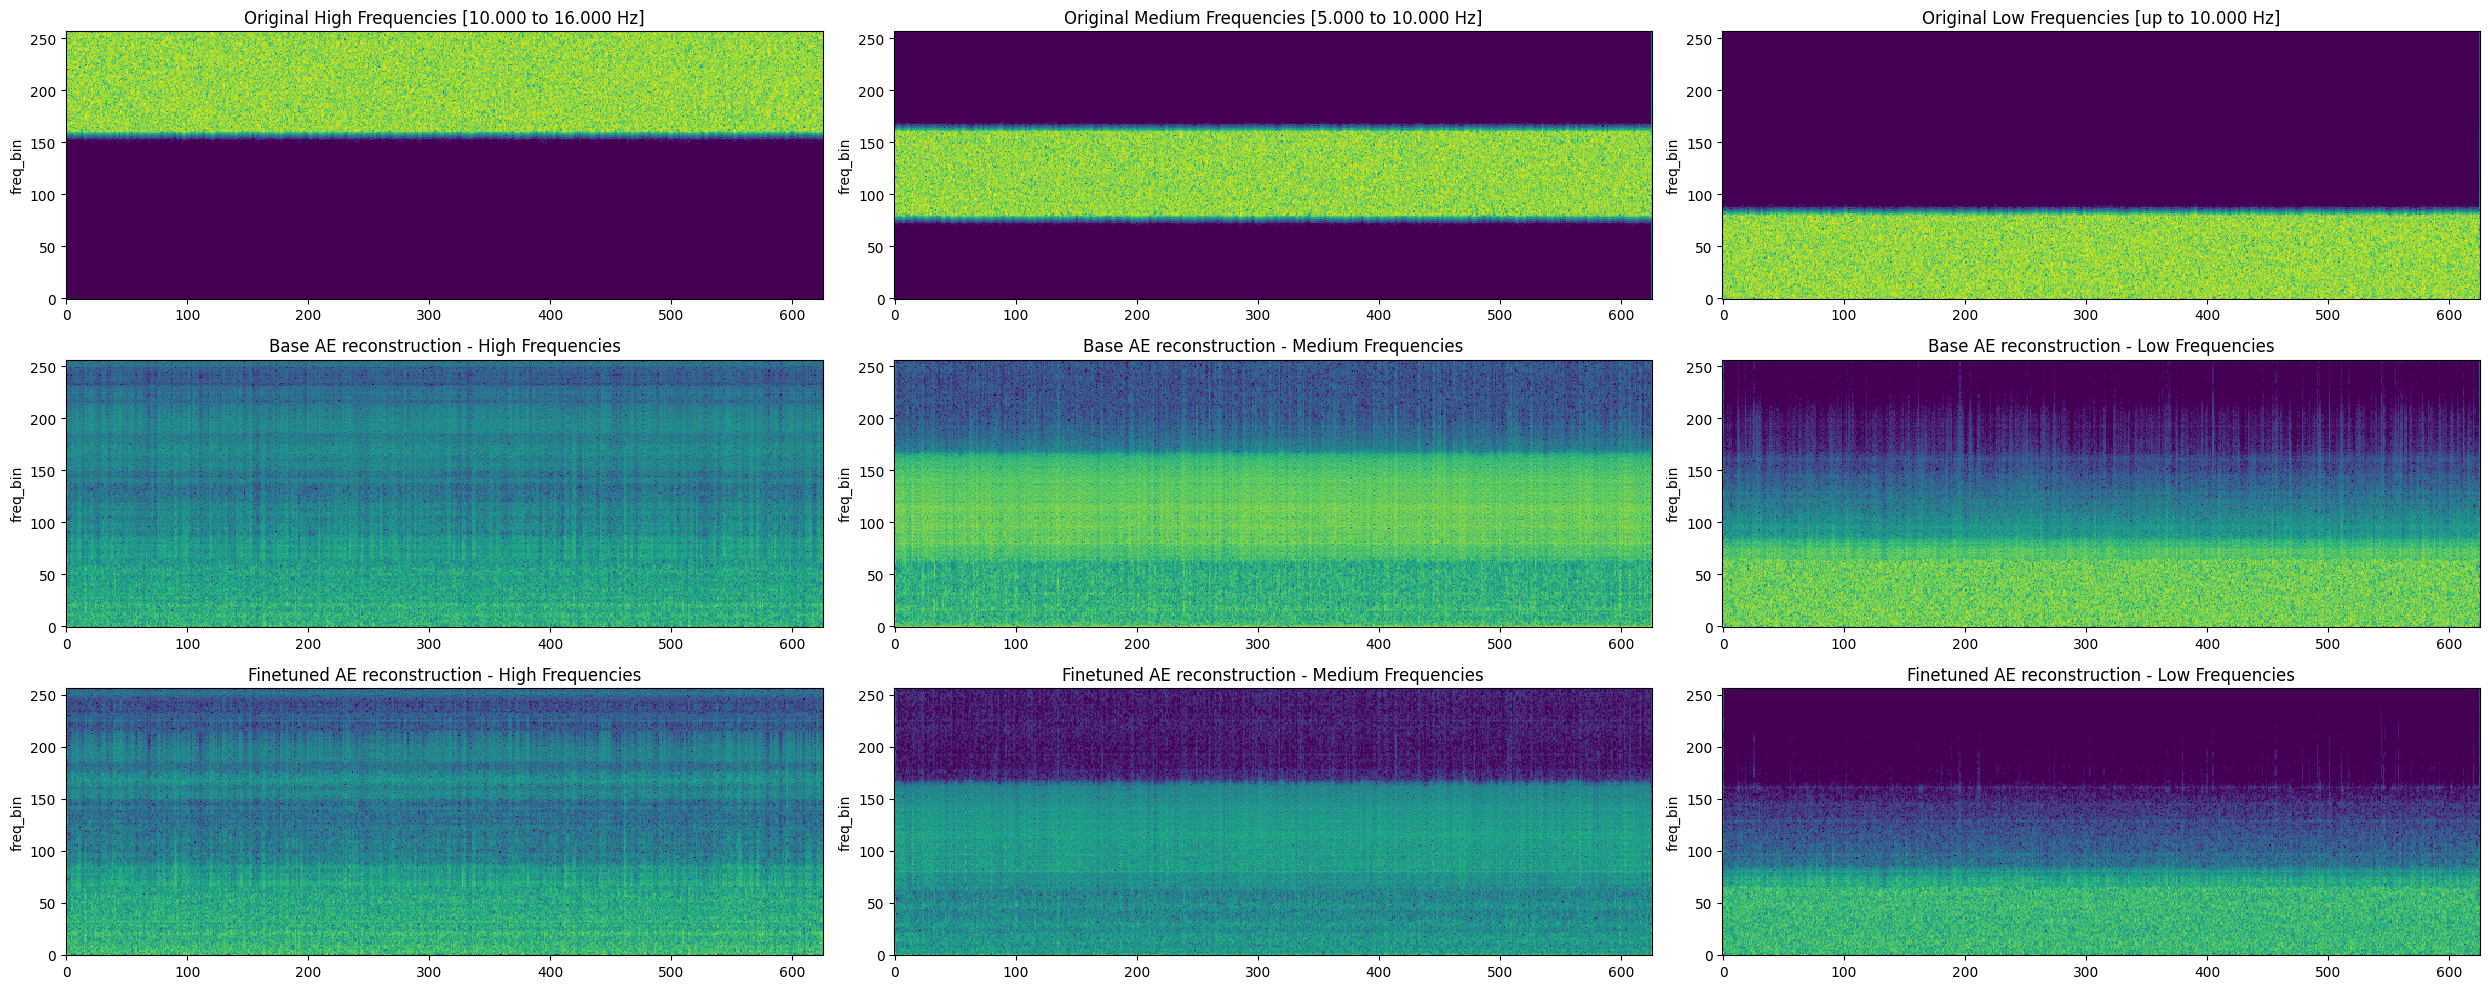

In [91]:
fig, axs = plt.subplots(3, 3, figsize=(25, 10))

# High Frequencies
high_bound = 16_000.0
low_bound  = 10_000.0

total_samples = waveform.shape[1]
noise = np.random.normal(0, 1, size=(2, total_samples))

recovered_signal = bandpass_filter(noise, low_bound=low_bound, high_bound=high_bound)
recovered_signal = torch.tensor(recovered_signal, dtype=torch.float32)

base_reconstructed_high_frequency_waveform = base_autoencoder(recovered_signal[None,:].to(device)).detach().cpu()[0]
reconstructed_high_frequency_waveform = pipeline.autoencoder(recovered_signal[None,:].to(device)).detach().cpu()[0]

plot_spectrogram(recovered_signal.mean(axis=0, keepdim=True), title=f'Original High Frequencies [10.000 to 16.000 Hz]', ax=axs[0][0])
plot_spectrogram(base_reconstructed_high_frequency_waveform, title=f'Base AE reconstruction - High Frequencies', ax=axs[1][0])
plot_spectrogram(reconstructed_high_frequency_waveform, title=f'Finetuned AE reconstruction - High Frequencies', ax=axs[2][0])

# Medium Frequencies
high_bound = 10_000.0
low_bound  = 5_000.0

total_samples = waveform.shape[1]
noise = np.random.normal(0, 1, size=(2, total_samples))

recovered_signal = bandpass_filter(noise, low_bound=low_bound, high_bound=high_bound)
recovered_signal = torch.tensor(recovered_signal, dtype=torch.float32)

base_reconstructed_high_frequency_waveform = base_autoencoder(recovered_signal[None,:].to(device)).detach().cpu()[0]
reconstructed_high_frequency_waveform = pipeline.autoencoder(recovered_signal[None,:].to(device)).detach().cpu()[0]

plot_spectrogram(recovered_signal.mean(axis=0, keepdim=True), title=f'Original Medium Frequencies [5.000 to 10.000 Hz]', ax=axs[0][1])
plot_spectrogram(base_reconstructed_high_frequency_waveform, title=f'Base AE reconstruction - Medium Frequencies', ax=axs[1][1])
plot_spectrogram(reconstructed_high_frequency_waveform, title=f'Finetuned AE reconstruction - Medium Frequencies', ax=axs[2][1])

# Low Frequencies
high_bound = 5_000.0
low_bound  = 0_000.0

total_samples = waveform.shape[1]
noise = np.random.normal(0, 1, size=(2, total_samples))

recovered_signal = bandpass_filter(noise, low_bound=low_bound, high_bound=high_bound)
recovered_signal = torch.tensor(recovered_signal, dtype=torch.float32)

base_reconstructed_high_frequency_waveform = base_autoencoder(recovered_signal[None,:].to(device)).detach().cpu()[0]
reconstructed_high_frequency_waveform = pipeline.autoencoder(recovered_signal[None,:].to(device)).detach().cpu()[0]

plot_spectrogram(recovered_signal.mean(axis=0, keepdim=True), title=f'Original Low Frequencies [up to 10.000 Hz]', ax=axs[0][2])
plot_spectrogram(base_reconstructed_high_frequency_waveform, title=f'Base AE reconstruction - Low Frequencies', ax=axs[1][2])
plot_spectrogram(reconstructed_high_frequency_waveform, title=f'Finetuned AE reconstruction - Low Frequencies', ax=axs[2][2])

fig.tight_layout()
plt.savefig('frequency_bands.png')

## Single Frequency

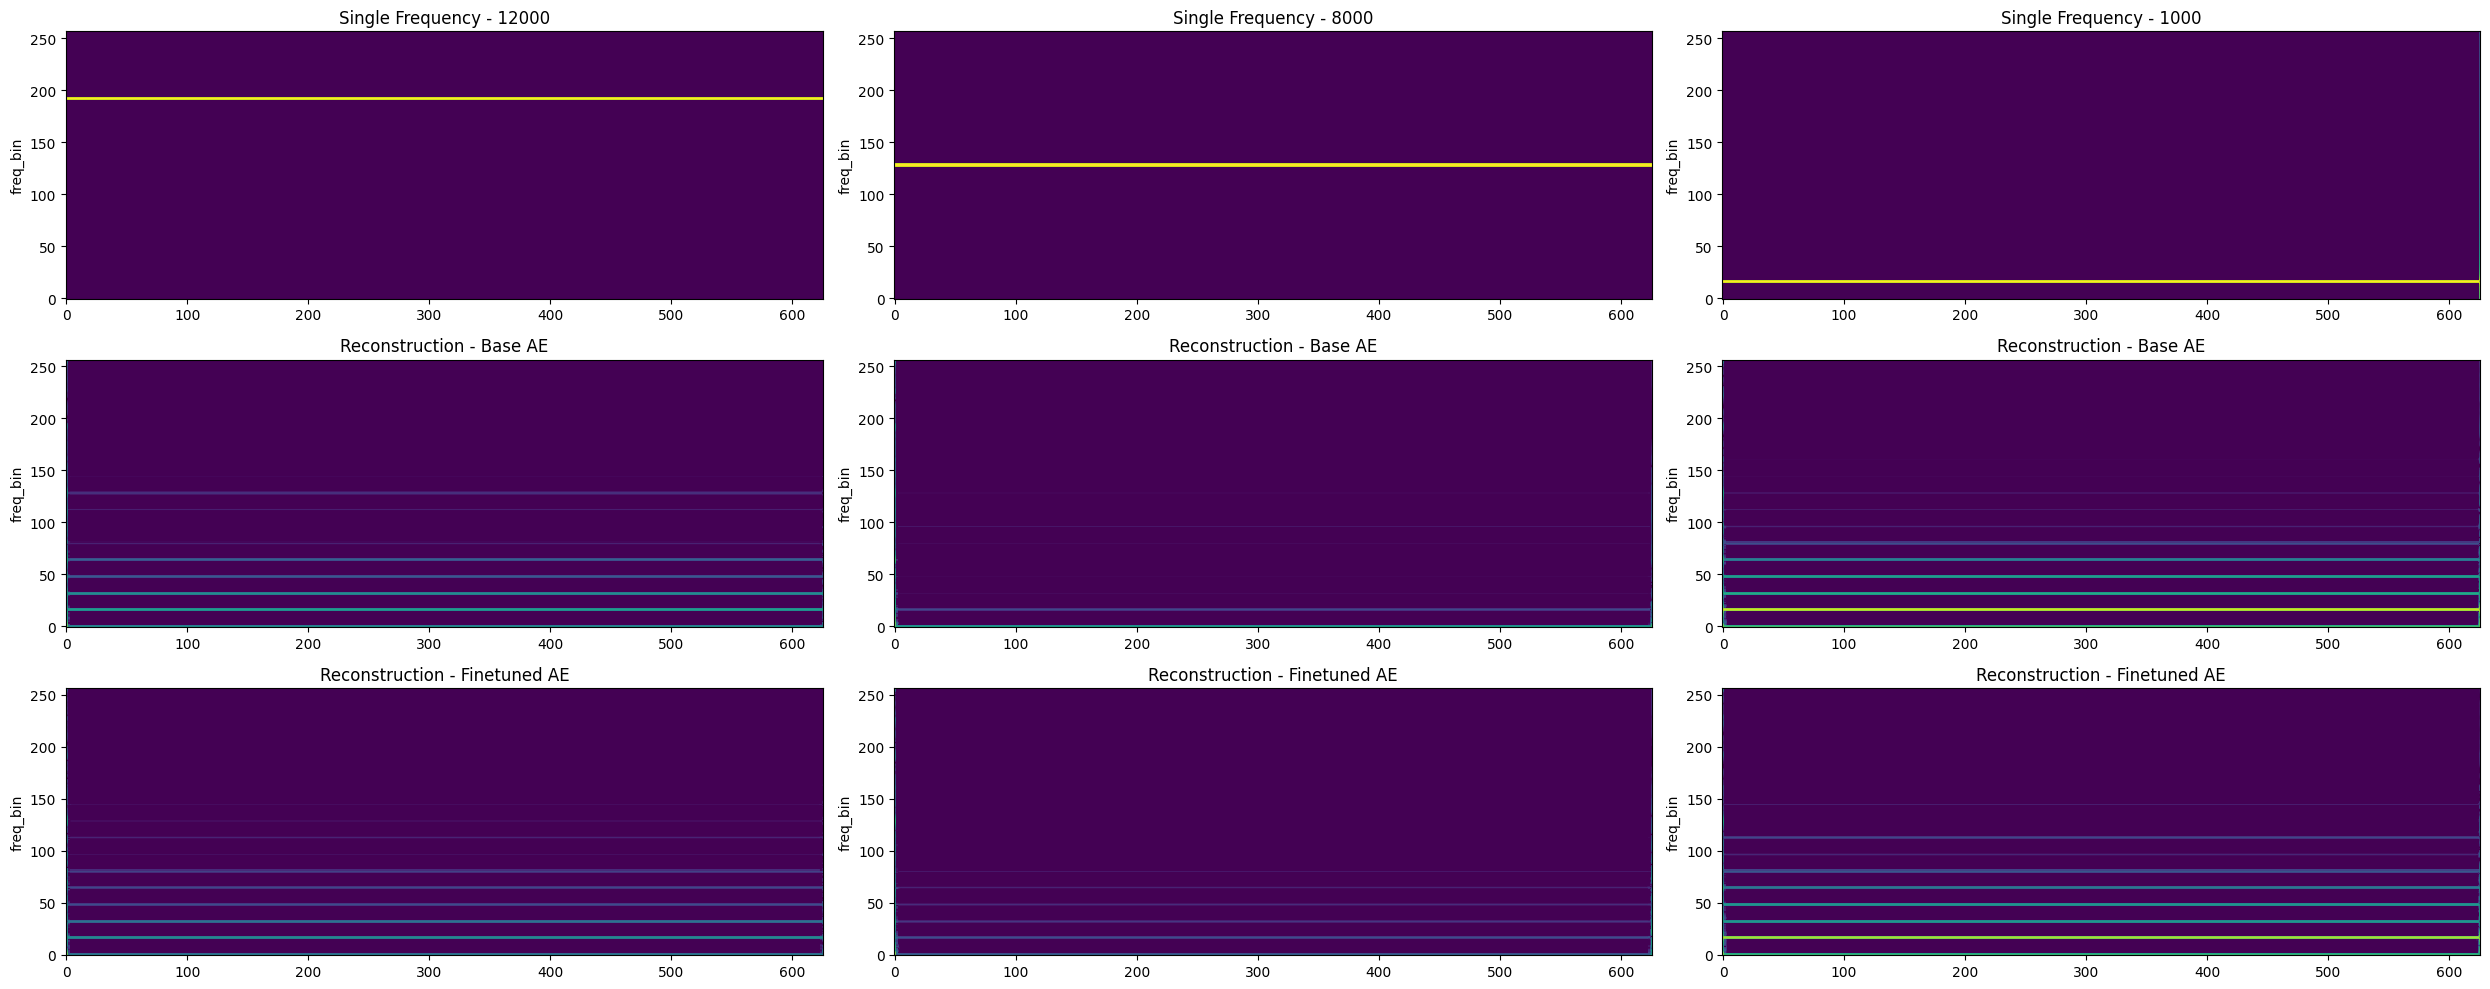

In [92]:
fig, axs = plt.subplots(3, 3, figsize=(25, 10))

# First interesting frequency
frequency = 12_000.0
duration  = 5
amplitude = 1.0

time_values = np.linspace(0, duration, int(32_000 * duration), endpoint=False)
single_frequency = amplitude * np.sin(2 * np.pi * frequency * time_values)
single_frequency = np.stack([single_frequency, single_frequency])
single_frequency = torch.tensor(single_frequency, dtype=torch.float32)

fine_reconstructed_high_frequency_waveform = pipeline.autoencoder(single_frequency[None,:].to(device)).detach().cpu()[0]
base_reconstructed_high_frequency_waveform = base_autoencoder(single_frequency[None,:].to(device)).detach().cpu()[0]

plot_spectrogram(single_frequency.mean(axis=0, keepdim=True), title=f'Single Frequency - {int(frequency)}', ax=axs[0][0])
plot_spectrogram(base_reconstructed_high_frequency_waveform, title='Reconstruction - Base AE', ax=axs[1][0])
plot_spectrogram(fine_reconstructed_high_frequency_waveform, title='Reconstruction - Finetuned AE', ax=axs[2][0])

# Second interesting frequency
frequency = 8_000.0
duration  = 5
amplitude = 1.0

time_values = np.linspace(0, duration, int(32_000 * duration), endpoint=False)
single_frequency = amplitude * np.sin(2 * np.pi * frequency * time_values)
single_frequency = np.stack([single_frequency, single_frequency])
single_frequency = torch.tensor(single_frequency, dtype=torch.float32)

fine_reconstructed_high_frequency_waveform = pipeline.autoencoder(single_frequency[None,:].to(device)).detach().cpu()[0]
base_reconstructed_high_frequency_waveform = base_autoencoder(single_frequency[None,:].to(device)).detach().cpu()[0]

plot_spectrogram(single_frequency.mean(axis=0, keepdim=True), title=f'Single Frequency - {int(frequency)}', ax=axs[0][1])
plot_spectrogram(base_reconstructed_high_frequency_waveform, title='Reconstruction - Base AE', ax=axs[1][1])
plot_spectrogram(fine_reconstructed_high_frequency_waveform, title='Reconstruction - Finetuned AE', ax=axs[2][1])

# Third interesting frequency
frequency = 1_000.0
duration  = 5
amplitude = 1.0

time_values = np.linspace(0, duration, int(32_000 * duration), endpoint=False)
single_frequency = amplitude * np.sin(2 * np.pi * frequency * time_values)
single_frequency = np.stack([single_frequency, single_frequency])
single_frequency = torch.tensor(single_frequency, dtype=torch.float32)

fine_reconstructed_high_frequency_waveform = pipeline.autoencoder(single_frequency[None,:].to(device)).detach().cpu()[0]
base_reconstructed_high_frequency_waveform = base_autoencoder(single_frequency[None,:].to(device)).detach().cpu()[0]

plot_spectrogram(single_frequency.mean(axis=0, keepdim=True), title=f'Single Frequency - {int(frequency)}', ax=axs[0][2])
plot_spectrogram(base_reconstructed_high_frequency_waveform, title='Reconstruction - Base AE', ax=axs[1][2])
plot_spectrogram(fine_reconstructed_high_frequency_waveform, title='Reconstruction - Finetuned AE', ax=axs[2][2])

fig.tight_layout()
plt.savefig('effects_on_different_frequencies.png')

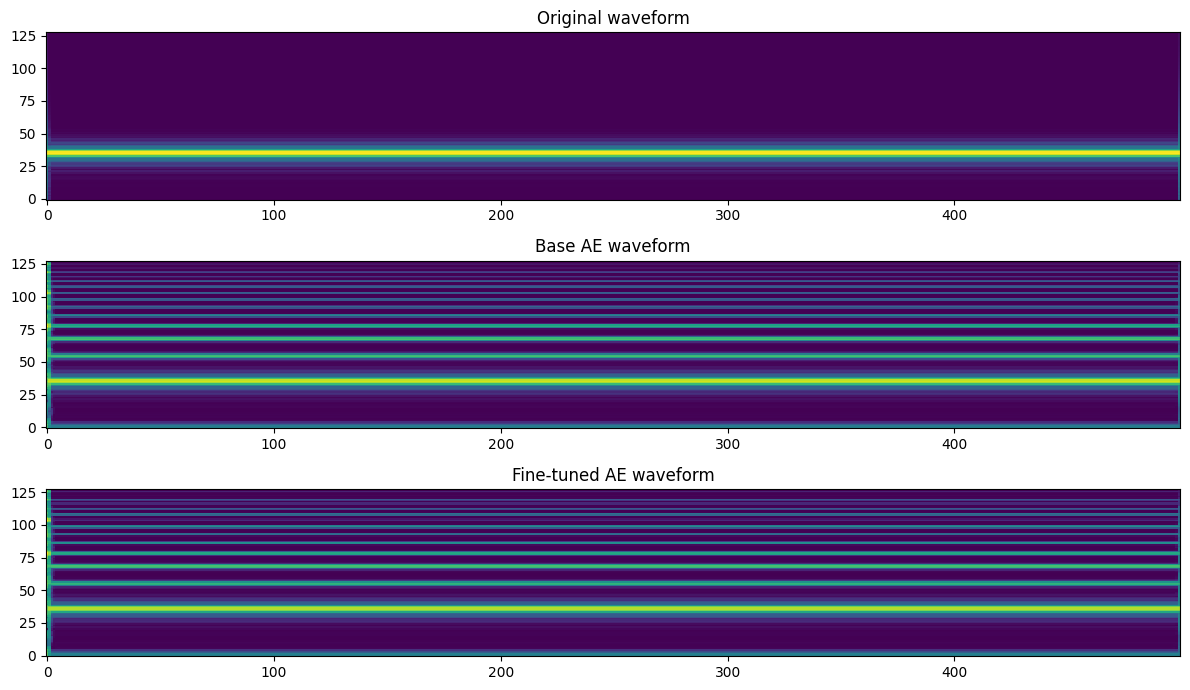

In [93]:
plain_mel_transformed = mel_transform(single_frequency.mean(axis=0, keepdim=True)[None, :].to(device)).detach().cpu()[0]
base_mel_transformed  = mel_transform(base_autoencoder(single_frequency[None, :].to(device))).detach().cpu()[0]
fine_mel_transformed  = mel_transform(pipeline.autoencoder(single_frequency[None, :].to(device))).detach().cpu()[0]

fig, axs = plt.subplots(3, 1, figsize=(12, 7))

axs[0].imshow(plain_mel_transformed[0], origin='lower', aspect='auto', interpolation='nearest')
axs[0].set_title('Original waveform')

axs[1].imshow(base_mel_transformed[0], origin='lower', aspect='auto', interpolation='nearest')
axs[1].set_title('Base AE waveform')

axs[2].imshow(fine_mel_transformed[0], origin='lower', aspect='auto', interpolation='nearest')
axs[2].set_title('Fine-tuned AE waveform')

fig.tight_layout()